In [3]:
import pandas as pd
import numpy as np
from scipy import stats, optimize, linalg
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import seaborn as sns
import adjustText

from collections import Counter, OrderedDict
import itertools

from pymodulon import io, core, plotting, util

from Bio import SeqIO
import cobra

# hide matplolib warnings
import warnings
warnings.filterwarnings( "ignore")

%load_ext rpy2.ipython

In [4]:
# set matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14
label_font = {'fontsize': 18}
text_font = {'fontsize': 12}
text_font_small = {'fontsize': 10}
tick_font = {'fontsize': 16}

In [6]:
usa_model = io.load_json_model('modulome-workflow/data/processed_data/saureus.json.gz')

# RNAseq data update

In [8]:
rnaseq_metadata = pd.read_csv('Paperdata/Staphylococcus_aureus_2022_02_26.tsv', sep='\t',
                             index_col=0)

In [9]:
usa300_data = pd.read_csv('Paperdata/metadata.tsv', sep='\t',
                         index_col=0)

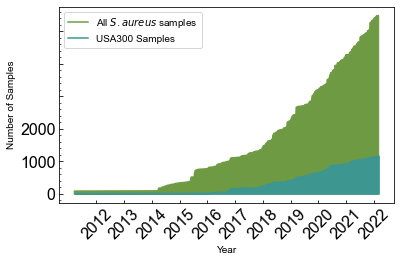

In [10]:
rnaseq_metadata['ReleaseDate'] = pd.to_datetime(rnaseq_metadata['ReleaseDate'])

first_date = min(rnaseq_metadata['ReleaseDate'])
last_date = max(rnaseq_metadata['ReleaseDate'])
date_range = pd.date_range(start=first_date,end=last_date,freq='YS')

fig,ax = plt.subplots(figsize=(6,4))
growth = rnaseq_metadata['ReleaseDate'].value_counts().sort_index().cumsum()
growth.plot(ax=ax,label='All $\it{S. aureus}$ samples', color='#6e9a44')

mdata = pd.to_datetime(usa300_data.ReleaseDate.fillna(pd.Timestamp('20220305')))
mdata['set_zero'] = first_date
mgrowth = mdata.value_counts().sort_index().cumsum()
mgrowth.plot(ax=ax, color='#3d9690', label='USA300 Samples')

ax.fill_between(mgrowth.index, mgrowth.values, color='#3d9690')
ax.fill_between(growth.index, growth.values, color='#6e9a44',zorder=0)


ax.tick_params(which='both', axis='both', direction='in', reset=True, top=False,
              right=False)
ax.set_xticklabels(np.arange(2012, 2023), fontsize=tick_font['fontsize'])
ax.set_yticklabels(np.arange(-1000, 3000, 1000), fontsize=tick_font['fontsize'])
ax.yaxis.set_minor_locator(MultipleLocator(100))

plt.xticks(date_range,date_range.strftime('%Y'),rotation=45,ha='center')
ax.tick_params()
ax.set_xlabel('Year')
ax.set_ylabel('Number of Samples')
plt.legend()

# plt.savefig('PaperFigs/RNAseq_accum.svg')

# PCA of Xnorm

Number of dimensions for 99% of variance: 182


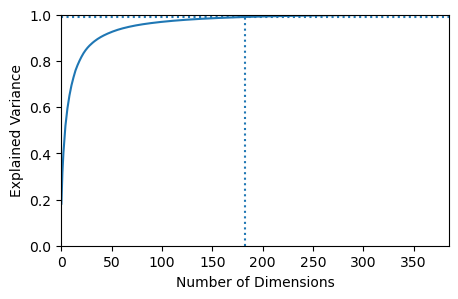

In [11]:
sns.reset_orig()

pca = PCA()
DF_weights = pd.DataFrame(pca.fit_transform(usa_model.X.transpose()),index=usa_model.X.columns)
DF_components = pd.DataFrame(pca.components_.T,index=usa_model.X.index)
var_cutoff = 0.99

fig,ax = plt.subplots(figsize=(5,3))
pca_var = np.cumsum(pca.explained_variance_ratio_)
ax.plot(pca_var)
dims = np.where(pca_var > var_cutoff)[0][0] + 1
ax.vlines(dims,0,1,linestyles='dotted')
ax.hlines(var_cutoff,0,len(usa_model.X.columns),linestyles='dotted')
ax.set_ylim(0,1)
ax.set_xlim(0,len(usa_model.X.columns))
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Number of Dimensions')
print ('Number of dimensions for 99% of variance:',dims)

# plt.savefig('PaperFigs/PCA_explained_variance.svg')

In [12]:
colors = sns.color_palette('Set2')
colors = colors[:-1]
colors.extend(sns.color_palette('dark')[:5])

In [13]:
replace = {'TSB + 0.4%glucose': 'TSB', 'CDM ': 'CDM'}
for idx, row in usa_model.sample_table.iterrows():
    if row.base_media in replace:
        usa_model.sample_table.loc[idx, 'base_media'] = replace[row.base_media]

In [14]:
isolate_colors = dict(zip(usa_model.sample_table.isolate.unique(), colors))
growth_colors = dict(zip(usa_model.sample_table.growth_phase.unique(), colors))
media_colors = dict(zip(usa_model.sample_table.base_media.unique(), colors))

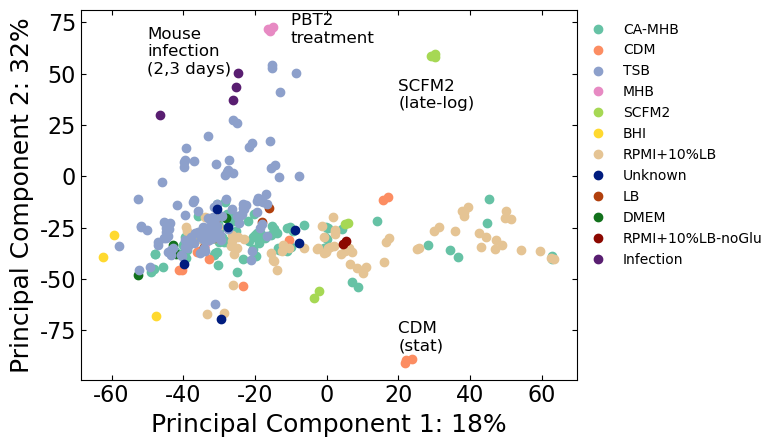

In [15]:
sns.reset_orig()

fig, ax = plt.subplots()
for idx, grp in usa_model.sample_table.groupby('base_media'):
    
    ax.scatter(DF_weights.loc[grp.index, 0], DF_weights.loc[grp.index, 1],
               color=media_colors[idx])

ax.set_xlabel(f'Principal Component 1: {pca_var[0] * 100:.0f}%',  **label_font)
ax.set_ylabel(f'Principal Component 2: {pca_var[1] * 100:.0f}%',  **label_font)

ax.tick_params(which='both', axis='both', direction='in', reset=True)
ax.set_xticklabels(np.arange(-80, 100, 20), fontsize=tick_font['fontsize'])
ax.set_yticklabels(np.arange(-100, 125, 25), fontsize=tick_font['fontsize'])

legend_elements = [Line2D([0], [0], marker='o', color=media_colors[i], label=i,
                          markerfacecolor=media_colors[i],
                          markersize=6, linewidth=0) for i in media_colors]

ax.legend(handles=legend_elements, frameon=False, bbox_to_anchor=(1.4, 1))

_ = ax.text(-30, 75, 'Mouse\ninfection\n(2,3 days)', **text_font)
_ = ax.text(40, 58, 'SCFM2 \n(late-log)', **text_font)
_ = ax.text(10, 90, 'PBT2 \ntreatment', **text_font)
_ = ax.text(40, -60, 'CDM \n(stat)', **text_font)


# plt.savefig('PaperFigs/PCA.svg')

# Treemap

In [16]:
tree_df = usa_model.imodulon_table[['imodulon_size','function']].reset_index()
tree_df['index'] = tree_df['index'].str.replace('Uncharacterized', 'Unc')
tree_df = tree_df.rename(columns={'index': 'name'})
tree_df.to_csv('Paperdata/tree_df.csv')

In [ ]:
%%R
library('treemap') #load treemap, make sure its installed in your env

# pdf("PaperFigs/treemap.pdf")

tree_df = read.csv('Paperdata/tree_df.csv', row.names='X') #load the data
treemap(tree_df, 
        index=c('function.', 'name'),
        vSize='imodulon_size',
        palette="Set3",
        border.col=c("white","black"),
       aspRatio=0.6) #make the treemap

# dev.off() #close 

# ICA Variance Explained

In [17]:
ic_var = []
for imodulon in usa_model.imodulon_names:
    ic_var.append(util.explained_variance(usa_model, imodulons=imodulon))
    
ic_var_name = dict(zip(ic_var, usa_model.imodulon_names))
ic_var_sum = np.insert(np.cumsum(sorted(ic_var, reverse=True)), 0, 0)

Text(64, 0.029, 'CodY')

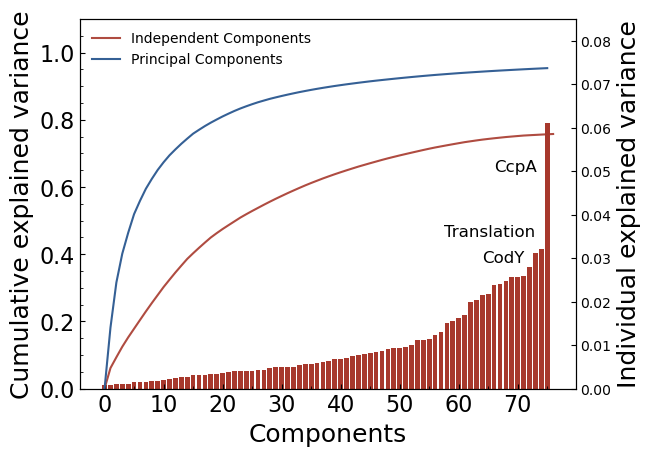

In [18]:
sns.reset_orig()
fig, ax = plt.subplots()
clr = sns.diverging_palette(250, 15, s=75, l=40,
                                  n=9, center="dark")
c1, c2 = clr[0], clr[-1]

# plot the variance explained of indiv iModulons
ax2 = ax.twinx()
ax2.bar(np.arange(len(ic_var)), sorted(ic_var), color=c2)
ax2.set_ylim(0, 0.085)


ax.plot(range(len(ic_var_sum)), ic_var_sum, label="Independent Components", color=c2,
       zorder=0, alpha=0.9)
ax.set_ylim(0, 1.1)
# Get PC explained variance
pca = PCA().fit(usa_model.X.T)
pc_var = np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0)

# Only keep number of PCs as ICs
pc_var = pc_var[: len(ic_var)]

# Plot PCs
ax.plot(range(len(ic_var)), pc_var, label="Principal Components", color=c1)

#set tick params
ax.tick_params(which='both', axis='both', direction='in')
ax2.tick_params(which='both', axis='both', direction='in')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

ax.set_xticklabels(np.arange(-10, 80, 10), fontsize=tick_font['fontsize'])
ax.set_yticklabels(np.arange(0, 12, 2)/10, fontsize=tick_font['fontsize'])

ax.legend(loc=2, frameon=False)

ax.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax.patch.set_visible(False)  # prevents ax1 from hiding ax2

ax.set_xlabel('Components', **label_font)
ax.set_ylabel('Cumulative explained variance', **label_font)
ax2.set_ylabel('Individual explained variance', **label_font)

# add labels to imodulons
ax2.text(66, 0.05, 'CcpA', zorder=0, **text_font)
ax2.text(57.5, 0.035, 'Translation', **text_font)
ax2.text(64, 0.029, 'CodY', **text_font)

# plt.savefig('PaperFigs/PCA_and_ICA_explained_variance.svg')

# iModulon precision and recall

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


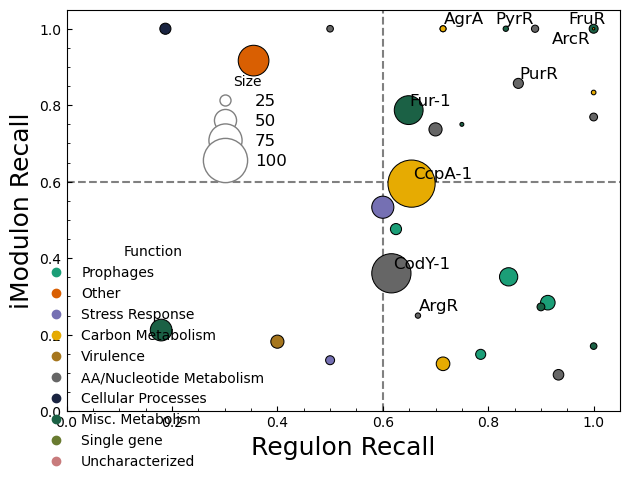

In [19]:
clr = sns.color_palette("Dark2", 7)[0:3]
clr.extend(sns.color_palette('Dark2')[5:9])
clr.extend(sns.color_palette('cubehelix'))

color_dict = dict(zip(set(usa_model.imodulon_table.function.values), clr))
fig, ax = plt.subplots()
auto_imods = usa_model.imodulon_table.dropna(subset=['precision'])
auto_imods['color'] = auto_imods.function.map(color_dict)
scatter = ax.scatter(auto_imods.precision, auto_imods.recall,
                     color=auto_imods.color,
                     s=auto_imods.imodulon_size ** 1.5, linewidth=0.75,
                     edgecolor='black', label=auto_imods.function)
    
ax.set_xlabel('Regulon Recall', **label_font)
ax.set_ylabel('iModulon Recall', **label_font)

ax.vlines(0.6, 0, 1.3, color='gray', zorder=-1, linestyle='--')
ax.hlines(0.6, 0, 1.3, color='gray', zorder=-1, linestyle='--')

ax.set_ylim(0, 1.05)
ax.set_xlim(0, 1.05)

ax.tick_params(which='both', axis='both', direction='in')
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

# add the legends
color_handle = [Line2D([0], [0], color=color_dict[i],
                marker='o', lw=0, label=i) for i in color_dict.keys()]

size_handle = [Line2D([0], [0], color=None, 
               markeredgecolor='gray', marker='o', markersize=i/3.14159,
               lw=0, label=i, markerfacecolor='white') 
               for i in np.arange(25, 125, 25)]

color_legend = plt.legend(handles=color_handle, frameon=False,
                          bbox_to_anchor=(0.38, 0.445), title='Function')

plt.legend(handles=size_handle, frameon=False, bbox_to_anchor=(0.425, 0.875), title='Size',
          labelspacing=0.3, fontsize=12)

# add labels
imod_txts = ['PurR', 'PyrR', 'CcpA-1', 'CodY-1', 'SaeR-1', 
             'AgrA', 'Fur-1', 'ArcR', 'SigB', 'ArgR', 'FruR']
texts = [ax.text(usa_model.imodulon_table.loc[i, 'precision'],
        usa_model.imodulon_table.loc[i, 'recall'],
        i, fontdict=text_font) for i in imod_txts]

adjustText.adjust_text(texts, arauto_imodsprops=dict(arauto_imodsstyle='-', color='black'))

plt.gca().add_artist(color_legend)
plt.tight_layout()

# plt.savefig('PaperFigs/Precision_Recall.svg')

# Sample Distribution

In [20]:
# base media
media_counts = usa_model.sample_table.base_media.value_counts()
media_counts['RPMI+10%LB'] = 73 
media_counts['TSB'] = 158 + 24
media_counts['CDM'] = 9
# media_counts = media_counts.drop(['RPMI+10%LB-noGlu', 'TSB + 0.4%glucose', 'CDM '])

# isolates
iso_counts = usa_model.sample_table.isolate.value_counts()
iso_counts['LAC'] = 130 + 20
iso_counts['JE2'] = 49 + 6
iso_counts = iso_counts.drop(['USA300 LAC', 'USA300_JE2'])

# growth_phase
gp_counts = usa_model.sample_table.growth_phase.value_counts()

In [21]:
def stacked_bar(axes, val_counts, height, cmap):
    bar_pos = np.insert(val_counts.cumsum().values, 0, 0)[:-1]
    axes.barh([height] * len(val_counts), val_counts.values, left=bar_pos,
       color=cmap, align='edge')
    for x, name in zip(bar_pos, val_counts.index):
        axes.text(x, height, name, fontdict=text_font_small)

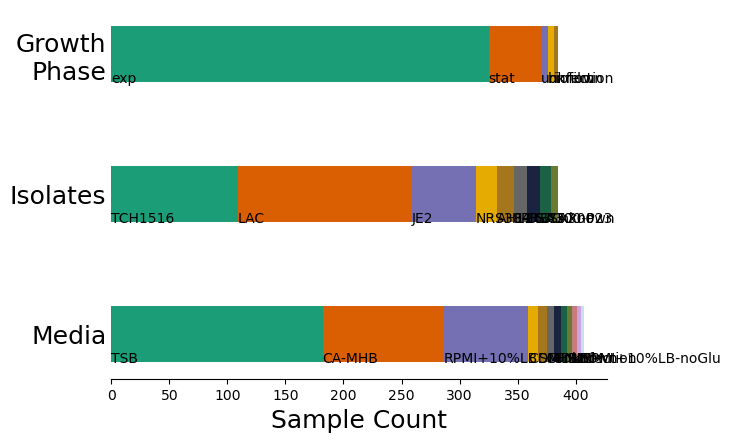

In [22]:
fig, ax = plt.subplots()
clr = sns.color_palette("Dark2", 7)[0:3]
clr.extend(sns.color_palette('Dark2')[5:9])
clr.extend(sns.color_palette('cubehelix'))

ys = [0, 2, 4]
stacked_bar(ax, media_counts, ys[0], clr)
stacked_bar(ax, iso_counts, ys[1], clr)
stacked_bar(ax, gp_counts, ys[2], clr)

# ax.set_ylim(-0.1,1)
ax.set_yticks([i + 0.4 for i in ys])
ax.set_yticklabels(['Media', 'Isolates', 'Growth\nPhase'], fontdict=label_font)

ax.set_xlabel('Sample Count', **label_font)
ax.tick_params(which='major', axis='y', length=0)

sns.despine(left=True)

# plt.savefig('PaperFigs/Sample_distribution.svg')

# iModulon Size distribution

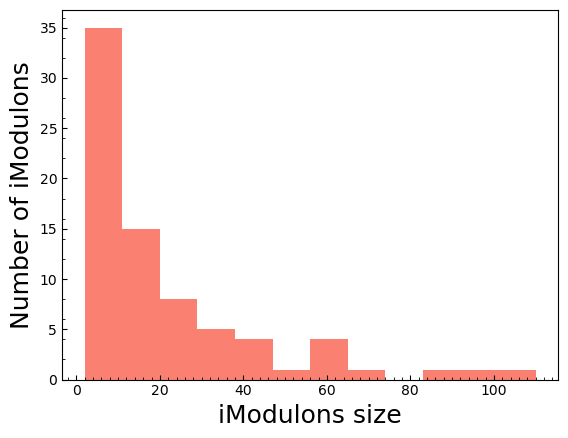

In [23]:
imod_size = [len(usa_model.view_imodulon(name)) for name in usa_model.imodulon_names]
fig, ax = plt.subplots()
_ = ax.hist(imod_size, bins=12, color='salmon')

ax.set_ylabel('Number of iModulons', **label_font)
ax.set_xlabel('iModulons size', **label_font)

ax.tick_params(which='both', axis='both', direction='in')
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(2))

# plt.savefig('PaperFigs/Imodulon_size_dist.svg')

# Gene iModulon Memebership
Distribution of number of iModulons different genes belong in

In [24]:
imod_members = [usa_model.view_imodulon(name).index.tolist() for name in usa_model.imodulon_names]
imod_counts = Counter(list(itertools.chain(*imod_members)))
gene_counts = Counter(imod_counts.values())
unique_genes = len(set(itertools.chain(*imod_members)))
gene_counts[0] = len(usa_model.M) - unique_genes
print(f'number of unqiue genes in iModulons: {unique_genes}')

number of unqiue genes in iModulons: 1231


Text(0, 0.5, 'Number of genes')

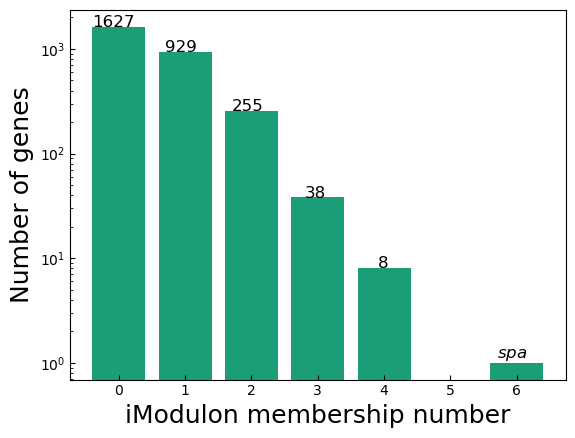

In [25]:
fig, ax = plt.subplots()
xs = np.arange(0, max(gene_counts.keys()) + 1)
ys = [gene_counts[i] if i in gene_counts else 0 for i in xs]
ax.bar(xs, ys, color=sns.color_palette("Dark2")[0])
ax.set_yscale('log')

ax.tick_params(which='both', axis='both', direction='in')

ax.text(5.7, 1.1, '$\it{spa}$', **text_font)
ax.text(-0.4, gene_counts[0], gene_counts[0], **text_font)
ax.text(0.7, gene_counts[1], gene_counts[1], **text_font)
ax.text(1.7, gene_counts[2], gene_counts[2], **text_font)
ax.text(2.8, gene_counts[3], gene_counts[3], **text_font)
ax.text(3.9, gene_counts[4], gene_counts[4], **text_font)


ax.set_xlabel('iModulon membership number', **label_font)
ax.set_ylabel('Number of genes', **label_font)

# plt.savefig('PaperFigs/Gene_imodulon_member.svg')

# Cluster the components

CodY deletion and mupirocin treatment intentionally'break' the relationship between CodY and CcpA; remove those samples before clustering

In [27]:
cody_temp_model = usa_model.copy()

# samples that separately activates CodY skews correlation, take them out
cody_activation = usa_model.A.T.loc[(usa_model.A.loc['CcpA-1'] > -12) &
                              (usa_model.A.loc['CodY-1'] > 20)]
cody_temp_model.A.drop(cody_activation.index, axis=1, inplace=True)

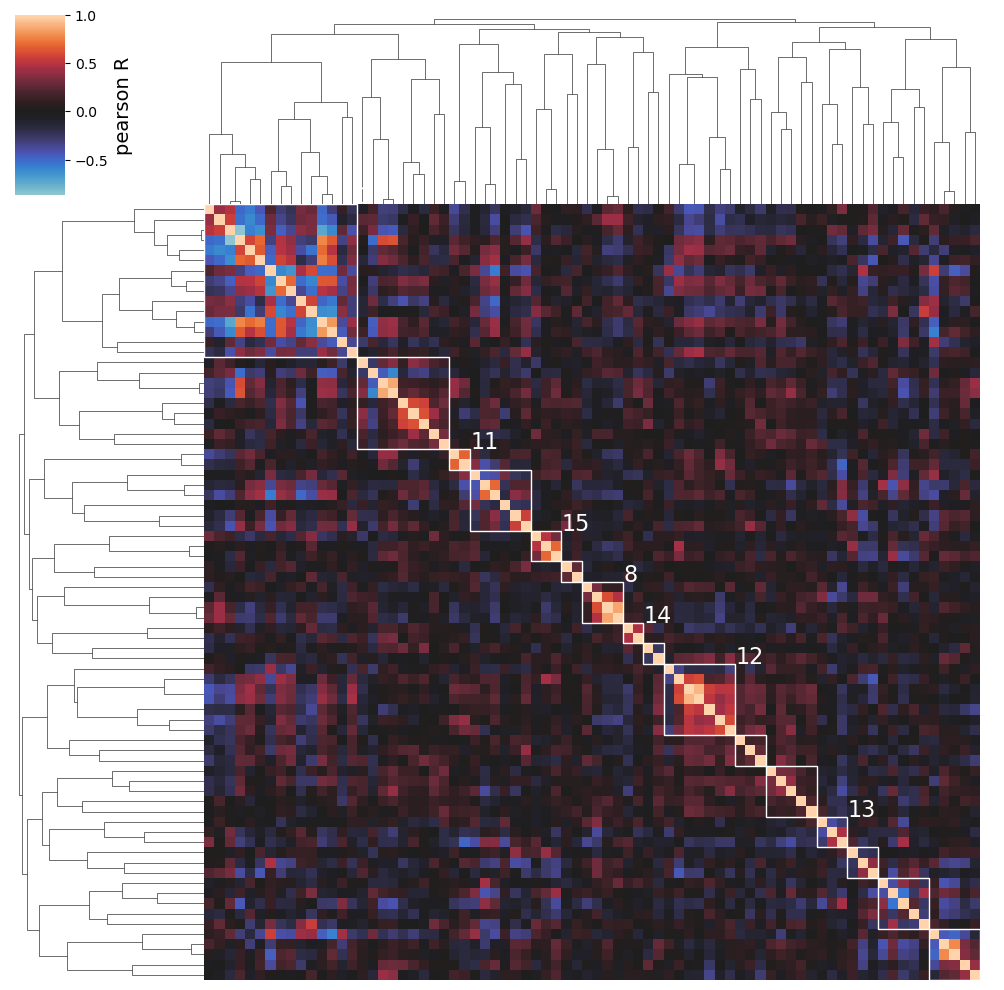

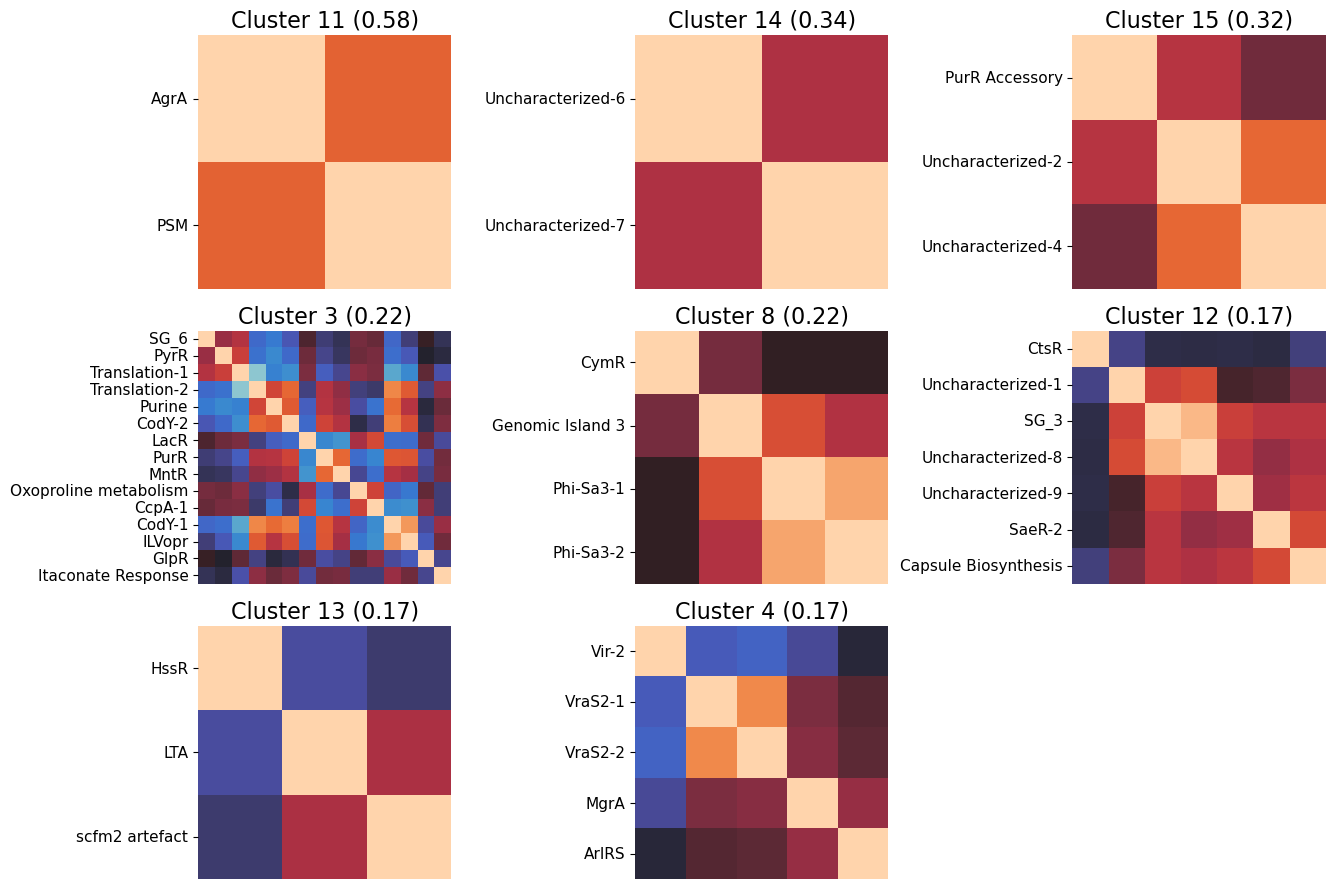

In [28]:
clst, cg = plotting.cluster_activities(cody_temp_model, correlation_method='pearson',
                            show_best_clusters=True, distance_threshold=0.91,
                                return_clustermap=True)
# cg.savefig('PaperFigs/A_cluster.svg')
# plt.savefig('PaperFigs/A_mini_cluster.svg')

# Translation iModulon

In [29]:
trans_df = pd.DataFrame(usa_model.M['Translation-1'])
trans_df['imod'] = np.where(trans_df.index.isin(usa_model.view_imodulon('Translation-1').index),
        'Translation\niModulon', 'Other')
trans_df['cog'] = np.where(trans_df.index.isin(usa_model.view_imodulon('Translation-1').index),
        usa_model.gene_table['COG'], 'Other')

Text(0.5, 0, '')

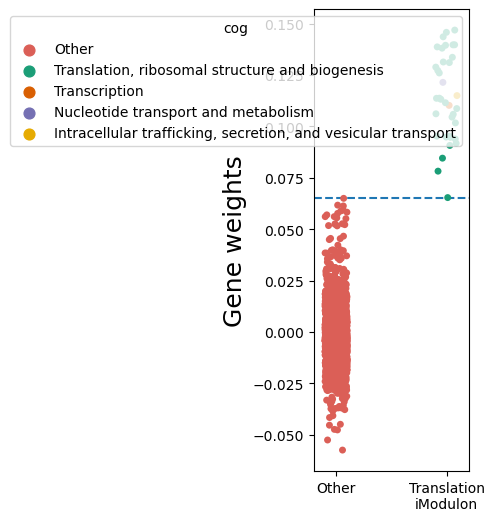

In [30]:
palette = list(sns.color_palette("hls", 1))
palette.extend(['#1b9e77', '#d95f02', '#7570b3', '#e6ab02'])
fig, ax = plt.subplots(figsize=(2,6))
sns.stripplot(x='imod', y='Translation-1', hue='cog', data=trans_df, ax=ax,
              palette=palette)
ax.hlines(usa_model.thresholds['Translation-1'],-0.5, 1.5, linestyle='--')
ax.set_xlim(-0.2, 1.2)
ax.set_ylabel('Gene weights', **label_font)
ax.set_xlabel('')
# plt.savefig('PaperFigs/Tranlation_imod_weights.svg')

# CcpA vs. CodY

In [31]:
# get the samples to highlight in the figure

glu_samples = pd.Index(['SRX6877996', 'SRX6877997',
              'SRX8387574', 'SRX8387576',
              'SRX8387561', 'SRX8387562', 'SRX6878019', 'SRX6878023',
                       'SG_3', 'SG_4'])

mouse_infection = usa_model.A.loc['CodY-1'].sort_values()[:4].index

ilv = set([i for i in usa_model.sample_table.genetic_changes if 'ilv' in i])
ilv_samps = usa_model.sample_table[usa_model.sample_table.genetic_changes.isin(ilv)].index

reg_samples = usa_model.A.T.index.difference(cody_activation.index | glu_samples | mouse_infection)
reg_samples = reg_samples.difference(ilv_samps)

In [32]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear,
                           usa_model.A.loc['CcpA-1', reg_samples].values,
                          usa_model.A.loc['CodY-1', reg_samples].values)
xd = np.linspace(usa_model.A.loc['CcpA-1', reg_samples].min(),
                usa_model.A.loc['CcpA-1', reg_samples].max())

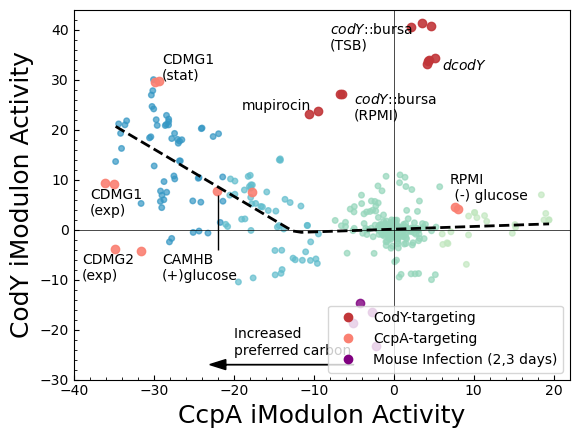

In [33]:
fig, ax = plt.subplots()
ax.scatter(usa_model.A.loc['CcpA-1', reg_samples],
            usa_model.A.loc['CodY-1', reg_samples],
            c=usa_model.A.loc['CcpA-1', reg_samples],
            s=16,
            cmap=ListedColormap(sns.color_palette('GnBu_r')[1:-1]),
          alpha=0.7)

# plot the CodY-KO
ax.scatter(usa_model.A.loc['CcpA-1', cody_activation.index],
           usa_model.A.loc['CodY-1', cody_activation.index], zorder=0,
           color=(0.7561707035755478, 0.21038062283737025, 0.22352941176470587),
           alpha=0.9)


ax.scatter(usa_model.A.loc['CcpA-1', glu_samples],
           usa_model.A.loc['CodY-1', glu_samples],
           color='salmon',
           alpha=0.9)

ax.scatter(usa_model.A.loc['CcpA-1', mouse_infection],
           usa_model.A.loc['CodY-1', mouse_infection],
           color='purple',
           alpha=0.8)

ax.plot(xd, piecewise_linear(xd, *p), zorder=1, color='black', linestyle='--',
        lw=2)

ax.vlines(0, -30, 44, lw=0.5, color='black')
ax.hlines(0, -40, 22, lw=0.5, color='black')

ax.set_xlim(-40, 22)
ax.set_ylim(-30, 44)

ax.tick_params(which='both', axis='both', direction='in', bottom=True)
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(2))

ax.set_xlabel('CcpA iModulon Activity', **label_font)
ax.set_ylabel('CodY iModulon Activity', **label_font)


ax.text(-8, 36, '$\it{codY}$::bursa\n(TSB)', **text_font_small)
ax.text(6, 32, '$d\it{codY}$', **text_font_small)
ax.text(-5, 22, '$\it{codY}$::bursa\n(RPMI)', **text_font_small)
ax.text(-19, 24, 'mupirocin', **text_font_small)
ax.text(-38, 3, 'CDMG1\n(exp)', **text_font_small)
ax.text(-29, 30, 'CDMG1\n(stat)', **text_font_small)
ax.text(-39, -10, 'CDMG2\n(exp)', **text_font_small)



ax.text(-29, -10, 'CAMHB\n(+)glucose', **text_font_small)
ax.arrow(-22, -4, 0, 11, overhang=0, head_width=0, head_length=0,color='black',
        length_includes_head=False, facecolor='black')

ax.text(7, 6, 'RPMI\n (-) glucose', **text_font_small)
# codY arrow
ax.text(-20, -25, 'Increased \npreferred carbon', **text_font_small)
ax.arrow(-5, -27, -18, 0, overhang=0, head_width=2, head_length=2, color='black',
        length_includes_head=True, facecolor='black')


# add legend
color_dict = {'CodY-targeting': (0.7561707035755478, 0.21038062283737025, 0.22352941176470587),
             'CcpA-targeting': 'salmon',
             'Mouse Infection (2,3 days)': 'purple'}
handle = [Line2D([0], [0], color=color_dict[i],
                marker='o', lw=0, label=i) for i in color_dict.keys()]

plt.legend(handles=handle, frameon=True, loc=4)
# plt.savefig('PaperFigs/Ccpa_Cody_activity_corr.svg')

# Manual Clustering

In [34]:
select_imods = usa_model.A.loc[['CcpA-1', 'CodY-1', 'ILVopr', 'LacR', 'PurR', 'MntR', 'PyrR',
                          'Translation-1']].drop(cody_activation.index, axis=1)
clusters = select_imods.T.corr()

In [35]:
%%capture
g = sns.clustermap(clusters)
reorder = [clusters.index[i] for i in g.dendrogram_row.reordered_ind]
triu = np.triu(clusters.loc[reorder, reorder], k=1)

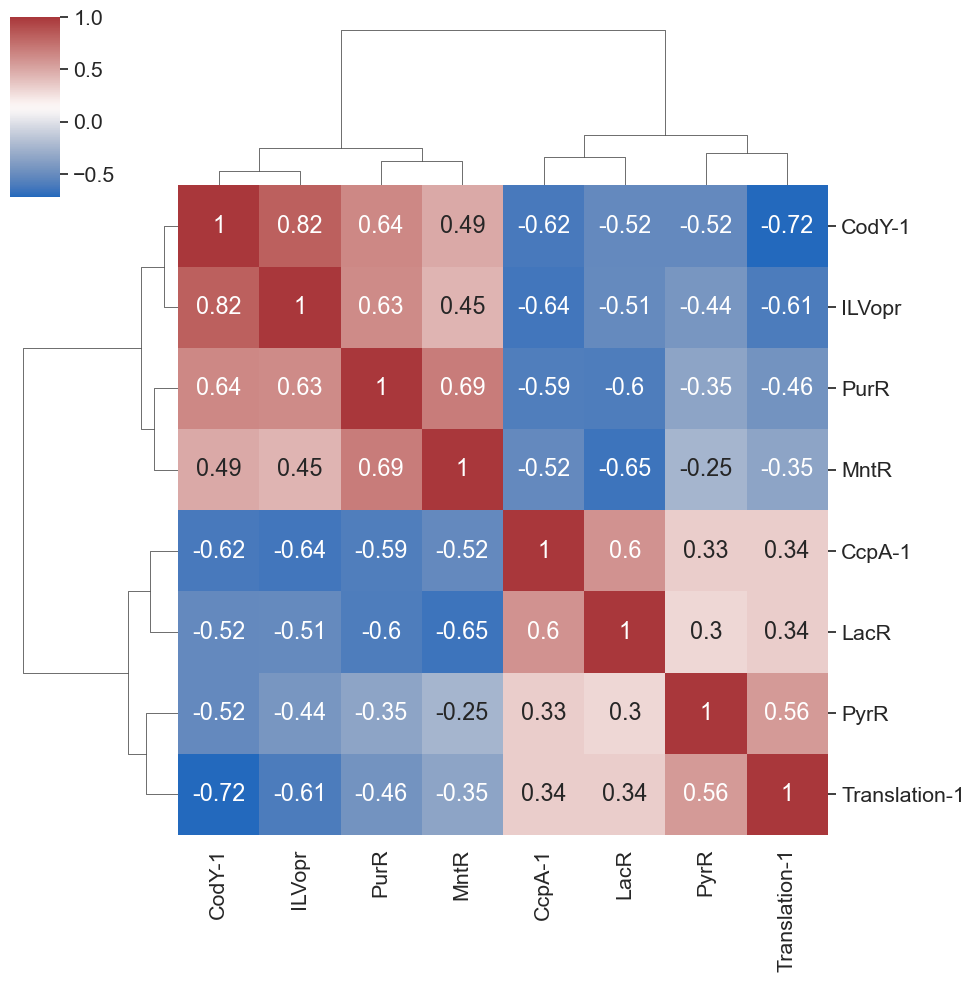

In [36]:
sns.set(font_scale=1.4)
ax = sns.clustermap(clusters, cmap='vlag', annot=True)
# ax.savefig('PaperFigs/Metabolic_cluster.svg')

# Metabolic modeling

In [95]:
#load model
MODEL_FILE = 'Paperdata/cobrapy/iYS854.json'
# model = cobra.io.load_json_model(MODEL_FILE)

# load all media compositions
media_comps = pd.read_excel('Paperdata/cobrapy/Media_comp.xlsx', skiprows=1, skipfooter=1, index_col=0)
media_comps = media_comps[~media_comps.index.isnull()]
media_comps.drop('References', axis=1, inplace=True)

# load the constraints for exchange reactions in CDMG
media_bounds = pd.read_excel('Paperdata/cobrapy/CDMG_bounds.xlsx', skiprows=1, skipfooter=1, index_col=0)
media_bounds.fillna(0, inplace=True)
media_bounds.replace('0*', 0, inplace=True)


def cs_model(model_file, media_comps, bounds=None, lb=-10):
    """
    Creates a media specific model with given media compoistions and exchange rates
    
    Parameters
    ----------
    model_file: str
        path to the baseline model json file
    media_comps: list, iterable
        iterable containing the exchange reaction ids that define composition of the media
    bounds: dict {str: tuple}
        dictionary with exchange reactions id as keys and tuple containing lower and 
        upper bound as values
    lb: float, default -10
        default lower bound for exchange reactions in the media that are not constrained by
        `bounds`
    """
    
    model = cobra.io.load_json_model(model_file)
    model.add_boundary(model.metabolites.get_by_id("pydam_e"), type="exchange")
    model.add_boundary(model.metabolites.get_by_id("ade_e"), type="exchange")
    
    # turn off all the exchange reactions except the media specific ones
    for rx in model.reactions:
        if rx.id.startswith("EX_"):
            rxlb = lb if rx.id in media_comps else 0
            model.reactions.get_by_id(rx.id).lower_bound = rxlb
            
    # constrain the reactions
    if not bounds:
        return model
    
    for rxn, bd in bounds.items():
        model.reactions.get_by_id(rxn).bounds = bd
        
    return model

cdmg_comp = media_comps.loc['CDM.v1+glucose'].dropna().values
cdmg_comp = np.delete(cdmg_comp, np.where(cdmg_comp == 'EX_cit_e'))
cdmg_comp = list(cdmg_comp)
cdmg_comp.extend(['EX_ade_e', 'EX_gua_e', 'EX_ca2_e', 'EX_met__L_e'])

cdmg_bounds = {}
for idx, row in media_bounds.iterrows():
    lb, ub = row['CDMG (lower bound)'], row['CDMG (upper bound)']
    cdmg_bounds.update({idx: (lb, ub)})
    
cdm_bounds = {}
for idx, row in media_bounds.iterrows():
     lb, ub = row['CDM (lower bound)'], row['CDM (upper bound)']
     cdm_bounds.update({idx: (lb, ub)})

cdmg_model = cs_model(MODEL_FILE,
                      cdmg_comp, bounds=cdmg_bounds)
cdmg_model.reactions.BIOMASS_iYS_reduced.objective_coefficient = 1
cdmg_model.reactions.BIOMASS_iYS_wild_type.objective_coefficient = 0

# same (non-reversible) reaction as GHMT2r, encoded by same gene.
# Alternate pFBA solutions sometimes uses GHMT2 other times GHMT2r
# removing it to make it consistent
cdmg_model.remove_reactions(['GHMT2'])

# get the fba solutions
cdmg_sol = cdmg_model.optimize()
cdmg_pfba = cobra.flux_analysis.pfba(cdmg_model)

cdm_model = cs_model(MODEL_FILE,
                     cdmg_comp, bounds=cdm_bounds)
cdm_model.reactions.BIOMASS_iYS_reduced.objective_coefficient = 1
cdm_model.reactions.BIOMASS_iYS_wild_type.objective_coefficient = 0
cdm_model.remove_reactions(['GHMT2'])

cdm_sol = cdm_model.optimize()
cdm_pfba = cobra.flux_analysis.pfba(cdm_model)

In [39]:
# usa model: GPR mapped to TCH1516 locus tags, lets us map CodY/CcpA iModulon genes to the model
usa_cobra = cobra.io.load_json_model('Paperdata/cobrapy/USA300_TCH1516_v75.json')


# get ccpa and cody associated reactions
def get_reactions(genlist, model, check_model):
    reactions = []
    for gene in genlist:
        try:
            mgene = model.genes.get_by_any(gene)
        except KeyError:
            continue
        else:
            for ginfo in mgene:
                rxns = [i.id for i in ginfo.reactions]
                for i in rxns:
                    try:
                        check_model.reactions.get_by_id(i)
                    except KeyError:
                        rxns.pop(rxns.index(i))
                reactions.extend(rxns)
    return list(set(reactions))

cody_reactions = get_reactions(usa_model.view_imodulon('CodY-1').index, usa_cobra, cdm_model)
ccpa_reactions = get_reactions(usa_model.view_imodulon('CcpA-1').index, usa_cobra, cdm_model)

# Pfba Solutions

In [96]:
pfba_res = [cdmg_pfba.fluxes.loc[cody_reactions].abs().sum(),
            cdm_pfba.fluxes.loc[cody_reactions].abs().sum(),
            cdmg_pfba.fluxes.loc[ccpa_reactions].abs().sum(),
            cdm_pfba.fluxes.loc[ccpa_reactions].abs().sum()]
sample = ['CDMG', 'CDM', 'CDMG', 'CDM']
imod = ['CodY', 'CodY', 'CcpA', 'CcpA']

pfba_data = pd.DataFrame([pfba_res, sample, imod], index=['data', 'Sample', 'iModulon']).T

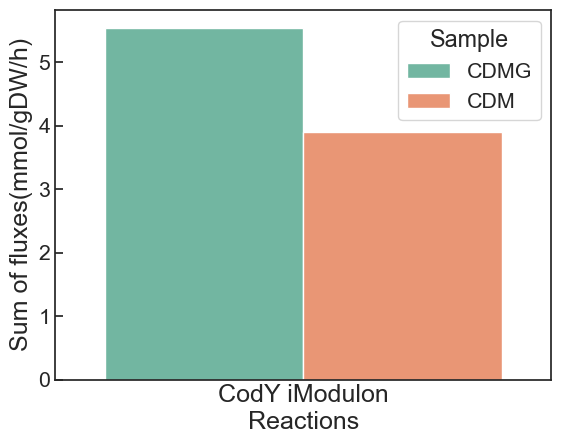

In [44]:
sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['ytick.left'] = True

fig, ax = plt.subplots()
sns.barplot(x='iModulon', y='data', hue='Sample', data=pfba_data[:2], palette='Set2', ax=ax)
ax.set_ylabel('Sum of fluxes(mmol/gDW/h)', fontdict=label_font)
ax.set_xlabel('', fontdict=label_font)

ax.set_xticklabels(['CodY iModulon\nReactions'],
                   fontdict=label_font)
# _ = ax.set_yticklabels(np.arange(0, 45, 5),fontsize=12)
ax.tick_params(which='both', axis='both', direction='in')

# plt.savefig('PaperFigs/pFBA_sum_of_fluxes.svg')

# Minspan Solutions

In [45]:
minspan = pd.read_csv('Paperdata/cobrapy/minspan_solved_fluxes.csv', index_col=0)
minspan.columns = minspan.columns.astype(int)

cdmg_samples = pd.read_csv('Paperdata/cobrapy/cdmg_sample_10e4.csv', index_col=0)
cdmg_samples = cdmg_samples[minspan.index]

cdm_samples = pd.read_csv('Paperdata/cobrapy/cdm_sample_10e4.csv', index_col=0)
cdm_samples = cdm_samples[minspan.index]

In [46]:
# normalize the minspan
norms = np.zeros((minspan.shape[1], minspan.shape[0]))
for i in minspan:
    norms[(i)] = minspan[i] / np.linalg.norm(minspan[i])

# check if normalized minspan is still in null space of S
Smat = pd.DataFrame(cobra.util.array.create_stoichiometric_matrix(cdmg_model),
            index=[i.id for i in cdmg_model.metabolites],
            columns=[i.id for i in cdmg_model.reactions])
np.allclose(np.dot(Smat[minspan.index], norms.T), 0)

True

In [47]:
norms = pd.DataFrame(norms.T, index=minspan.index, columns=minspan.columns)

# project MCMC samples into minspan pathways
cdmg_alpha_norm, *_ = linalg.lstsq(norms, cdmg_samples.T)
cdm_alpha_norm, *_ = linalg.lstsq(norms, cdm_samples.T)

cdmg_alpha_norm = pd.DataFrame(cdmg_alpha_norm)
cdm_alpha_norm = pd.DataFrame(cdm_alpha_norm)

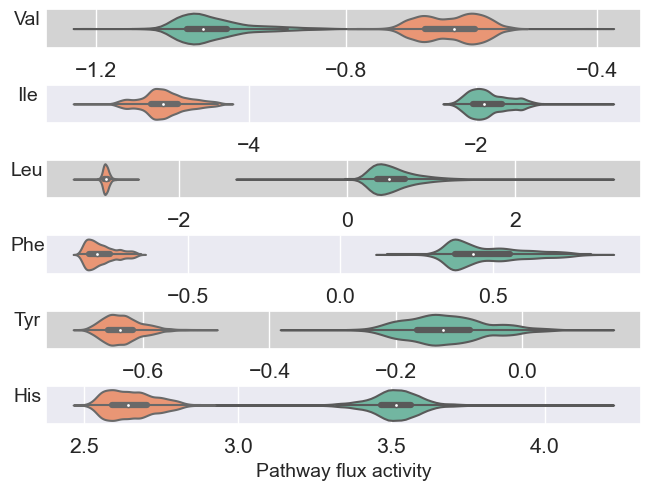

In [53]:
tf = [0.4, 2, 2,  0.5, 0.2, 0.5] #tick freq.
ylabs = ['Val', 'Ile', 'Leu',  'Phe', 'Tyr', 'His']
paths = [210, 58, 146,  148, 14, 111] # columns in minspan matrix
sns.set_style('darkgrid') 
fig, ax = plt.subplots(6, 1, sharey=False)
for i, p in enumerate(paths):
    sns.violinplot(x=cdmg_alpha_norm.loc[p], ax=ax[i], color=sns.color_palette('Set2')[0],
               fill=True)
    sns.violinplot(x=cdm_alpha_norm.loc[p], ax=ax[i], color=sns.color_palette('Set2')[1],
              fill=True)
    yl = ax[i].set_ylabel(ylabs[i], fontsize=14)
    yl.set_rotation(0)
    ax[i].set_xlabel('')
    ax[i].set_title('')
    ax[i].xaxis.set_major_locator(MultipleLocator(tf[i]))
    if i%2 == 0:
        ax[i].set_facecolor('lightgray')
        
ax[-1].set_xlabel('Pathway flux activity', fontsize=14)
fig.tight_layout(pad=0.2)

# plt.savefig('PaperFigs/sampling_pathway_fluxes.svg')

# Intersection pFBA

In [97]:
cdmg_f = [cdmg_pfba.fluxes.loc['GHMT2r'], cdmg_pfba.fluxes.loc['GCCb']]
cdm_f = [cdm_pfba.fluxes.loc['GHMT2r'], cdm_pfba.fluxes.loc['GCCb']]
data_df = pd.DataFrame([cdmg_f, cdm_f], index=['CDMG', 'CDM'], columns=['GHMT2r', 'GCCa/b'])
data_df

,GHMT2r,GCCa/b
CDMG,-0.064940,0.000000
CDM,0.502894,0.543184


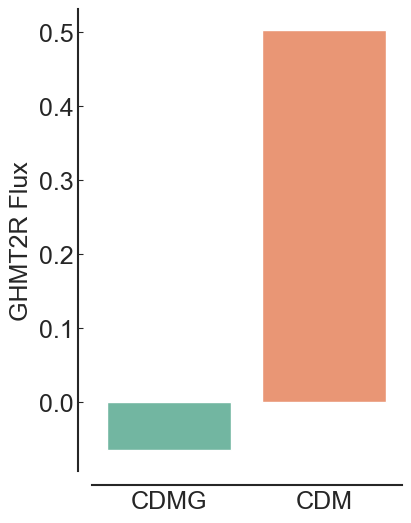

In [98]:
sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['ytick.left'] = True

fig, ax = plt.subplots(figsize=(4, 6))
sns.barplot(x=['CDMG', 'CDM'], y=data_df['GHMT2r'], palette=sns.color_palette('Set2'), ax=ax)
ax.set_ylabel('GHMT2R Flux', fontdict=label_font)

sns.despine(offset=10)
ax.set_xticklabels(['CDMG', 'CDM'], fontdict=label_font)
_ = ax.set_yticklabels(np.arange(-1, 7, 1) / 10, fontdict=label_font)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1.5)
    
ax.tick_params(which='both', axis='both', direction='in')

# plt.savefig('PaperFigs/GHMT2R_flux.svg')

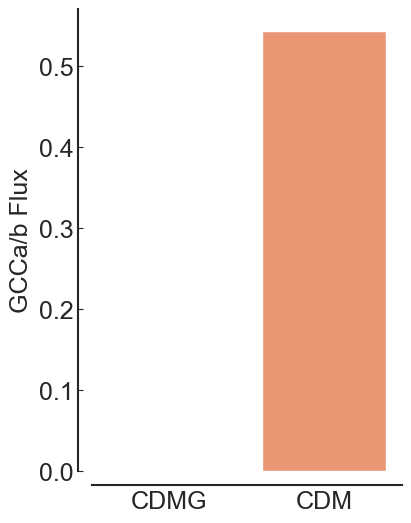

In [99]:
fig, ax = plt.subplots(figsize=(4, 6))
sns.barplot(x=['CDMG', 'CDM'], y=data_df['GCCa/b'], palette=sns.color_palette('Set2'), ax=ax)
ax.set_ylabel('GCCa/b Flux', fontdict=label_font)
sns.despine(offset=10)

ax.set_xticklabels(['CDMG', 'CDM'], fontdict=label_font)
_ = ax.set_yticklabels(np.arange(0, 6, 1) / 10, fontdict=label_font)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1.5)

ax.tick_params(which='both', axis='both', direction='in')
# plt.savefig('PaperFigs/GCC_flux.svg')

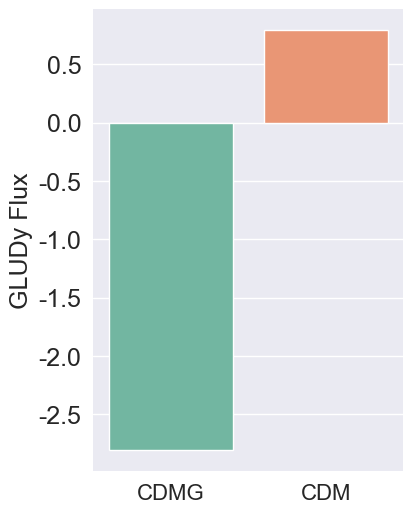

In [54]:
data = [cdmg_pfba.fluxes.loc['GLUDy'], cdm_pfba.fluxes.loc['GLUDy']]
fig, ax = plt.subplots(figsize=(4, 6))
sns.barplot(x=['CDMG', 'CDM'], y=data, palette=sns.color_palette('Set2'), ax=ax,
           dodge=False)

sns.despine(offset=5)
ax.set_ylabel('GLUDy Flux', fontdict=label_font)
ax.set_xticklabels(['CDMG', 'CDM'], fontdict=tick_font)
_ = ax.set_yticklabels(np.arange(-3, 1, 0.5), fontdict=label_font)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1.5)

ax.tick_params(which='both', axis='both', direction='in')

# plt.savefig('PaperFigs/GLUDy_flux.svg')

In [55]:
def get_metab_summary(sol, model, metab):
    reactions = [i.id for i in model.metabolites.get_by_id(metab).reactions]
    fluxes = sol.fluxes.loc[reactions]
    df = pd.DataFrame([reactions, fluxes], index=['reactions', 'fluxes']).T
    df = df[df.fluxes.abs() > 0.00001]
    for idx, row in df.iterrows():
        df.loc[idx, 'flow'] = get_dir(row.reactions, metab, model, row.fluxes)
    for name, grp in df.groupby('flow'):
        tot = grp.fluxes.abs().sum()
        for idx, row in grp.iterrows():
            df.loc[idx, 'percent'] = abs(row.fluxes / tot) * 100
    df = df.sort_values(['flow', 'percent'], ascending=False).reset_index(drop=True)
    return df.set_index(['flow', 'reactions'])

def get_dir(rid, metab, model, flux):
    rxn = model.reactions.get_by_id(rid)
    reactant = True if metab in [i.id for i in rxn.reactants] else False
    if (reactant and flux < 0) or (not reactant and flux > 0):
        flow = 'producing'
    else:
        flow = 'consuming'
    return flow

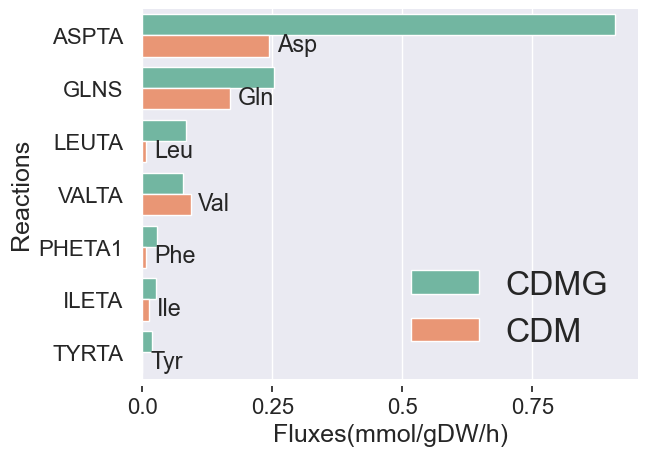

In [57]:
aa_bs = ['ASPTA', 'GLNS', 'LEUTA', 'VALTA', 'PHETA1', 'ILETA', 'TYRTA']
aa_name = ['Asp', 'Gln', 'Leu', 'Val', 'Phe', 'Ile', 'Tyr']
yticks = [f'{rname}\n({aname})' for rname, aname in zip(aa_bs, aa_name)]
aa_fluxes = [abs(cdmg_pfba.fluxes.loc[i]) for i in aa_bs]
aa_fluxes.extend([abs(cdm_pfba.fluxes.loc[i]) for i in aa_bs])
media = ['CDMG'] * 7
media.extend(['CDM'] * 7)
data_df = pd.DataFrame([aa_fluxes, aa_bs * 2, media], index=['Flux', 'Reaction', 'Media']).T

fig, ax = plt.subplots()
sns.barplot(y='Reaction', x='Flux', hue='Media', data=data_df, palette='Set2', ax=ax)
sns.despine(offset=10)

aa_map = dict(zip(aa_bs, aa_name))
for idx, row in data_df[data_df.Media == 'CDM'].iterrows():
    aname = aa_map[row.Reaction]
    ax.text(row.Flux + 0.03, idx-6.7, aname)
    
ax.set_xlabel('Fluxes(mmol/gDW/h)', fontdict=label_font)
ax.set_ylabel('Reactions', fontdict=label_font)
_ = ax.set_xticklabels(np.arange(0, 2, 0.25), fontdict=tick_font)
_ = ax.set_yticklabels(aa_bs, fontdict=tick_font)


    
plt.legend(frameon=False, fontsize='x-large', loc=4)
ax.tick_params(which='both', axis='both', direction='in', bottom=True, size=5)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1.5)
# plt.savefig('PaperFigs/AA_biosynth_flux.svg')

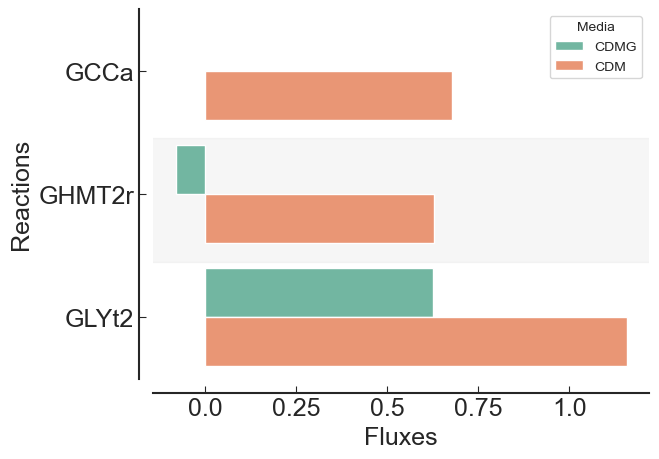

In [100]:
gf_rxns = ['GCCa', 'GHMT2r', 'GLYt2']
aa_fluxes = [cdmg_pfba.fluxes.loc[i] for i in gf_rxns]
_ = aa_fluxes.extend([cdm_pfba.fluxes.loc[i] for i in gf_rxns])
media = ['CDMG'] * 3
media.extend(['CDM'] * 3)
data_df = pd.DataFrame([aa_fluxes, gf_rxns * 2, media], index=['Flux', 'Reaction', 'Media']).T

fig, ax = plt.subplots()
sns.barplot(y='Reaction', x='Flux', hue='Media', data=data_df, palette='Set2', ax=ax)
sns.despine(offset=10)

ax.set_xlabel('Fluxes', fontdict=label_font)
ax.set_ylabel('Reactions', fontdict=label_font)
_ = ax.set_xticklabels(np.arange(-0.25, 2, 0.25), fontdict=label_font)
_ = ax.set_yticklabels(gf_rxns, fontdict=label_font)

ax.tick_params(which='both', axis='both', direction='in', bottom=True, size=5)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1.5)

rect = Rectangle((-0.5, 0.55), 2, 1, color='lightgray', alpha=0.2, zorder=-1)
ax.add_patch(rect)

# plt.savefig('PaperFigs/Glycine_folate_cycle.svg')

# Find intersection metabolites

In [59]:
ccpa_metabs = []
cody_metabs = []
for i in cody_reactions:
    rxn = cdm_model.reactions.get_by_id(i)
    for metabs in rxn.metabolites:
        cody_metabs.append(metabs.id)
for i in ccpa_reactions:
    rxn = cdm_model.reactions.get_by_id(i)
    for metabs in rxn.metabolites:
        ccpa_metabs.append(metabs.id)

In [60]:
common_metabs = ['adp_c', 'atp_c', 'co2_c', 'coa_c', 'h2o_c', 'h_c', 'h_e',
                'na1_c', 'na1_e', 'nad_c', 'nadh_c', 'nadph_c', 'nh4_c', 'pi_c', 
                'nadp_c']
shared_metabs = set(ccpa_metabs).intersection(cody_metabs).difference(common_metabs)
len(shared_metabs)

22

In [61]:
metabs_info = []
for i in shared_metabs:
    m = cdm_model.metabolites.get_by_id(i)
    codyr = ';'.join([i.name for i in m.reactions if i.id in cody_reactions])
    ccpar = ';'.join([i.name for i in m.reactions if i.id in ccpa_reactions])
    metabs_info.append((m.name, codyr, ccpar))
    print(m.name, len(codyr.split(';')), len(ccpar.split(';')))

L-Phenylalanine 1 1
Acetaldehyde 1 1
Oxaloacetate 1 2
N-Succinyl-2-L-amino-6-oxoheptanedioate 1 1
L-Histidine 1 1
L-Tryptophan 1 1
Glycerol 1 3
Glyceraldehyde 3-phosphate 1 2
Pyruvate 4 8
5,6,7,8-Tetrahydrofolate 1 1
Glycine 1 2
L-Alanine 2 1
L-Aspartate 2 2
Succinyl-CoA 1 2
2-Oxoglutarate 8 5
L-Arginine 1 1
L-Glutamate 12 5
D-Glyceraldehyde 1 1
L-Tyrosine 1 1
5,10-Methylenetetrahydrofolate 1 1
L-Threonine 2 1
Acetyl-CoA 2 3


In [62]:
metab_df = pd.DataFrame(metabs_info, columns=['Metabolite', 'CodY reactions', 'CcpA Reactions'])
# metab_df.to_csv('Paperdata/metabs_df.csv')

# HPF weighting

Text(0, 0.5, 'CodY component gene weight')

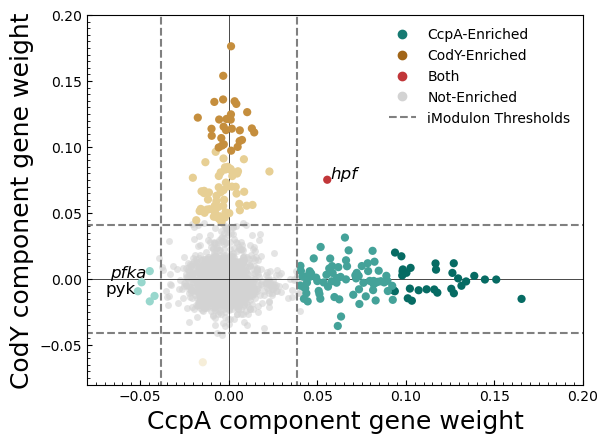

In [63]:
sns.reset_orig()
ccpa_bins = pd.cut(usa_model.M['CcpA-1'], bins=3, labels=False)
cody_bins = pd.cut(usa_model.M['CodY-1'], bins=3, labels=False)
ccpa_lt = usa_model.view_imodulon('CcpA-1').index
cody_lt = usa_model.view_imodulon('CodY-1').index

either = ccpa_lt.union(cody_lt)
neither = usa_model.M.index.difference(either)

def assign_color(lt, ccpa_bins=ccpa_bins, cody_bins=cody_bins,
                ccpa_genes=ccpa_lt, cody_genes=cody_lt):
    clrmap = sns.color_palette('BrBG', 8)
    if lt in ['USA300HOU_RS04065']:
        return (0.7561707035755478, 0.21038062283737025, 0.22352941176470587) # red
    elif lt in ccpa_lt:
#         return clrmap[-1]
        return clrmap[ccpa_bins[lt] + 5]
#     return clrmap[0]
    return clrmap[3 - cody_bins[lt]]
    # sns.color_palette('PRGn')[1]

fig, ax = plt.subplots()
ax.scatter(usa_model.M.loc[either, 'CcpA-1'], usa_model.M.loc[either, 'CodY-1'], 
            color=either.map(assign_color), s=35, zorder=2, lw=0)

ax.scatter(usa_model.M.loc[neither, 'CcpA-1'], usa_model.M.loc[neither, 'CodY-1'], 
           s=25, color='lightgray', zorder=-1, alpha=0.6, lw=0)

ax.vlines(usa_model.thresholds['CcpA-1'] - 0.002, -0.1, 0.2, linestyle='--', color='gray')
ax.vlines(-usa_model.thresholds['CcpA-1'] + 0.002, -0.1, 0.2, linestyle='--', color='gray')
ax.hlines(usa_model.thresholds['CodY-1'] - 0.002, -0.1, 0.2, linestyle='--', color='gray')
ax.hlines(-usa_model.thresholds['CodY-1'] + 0.002, -0.1, 0.2, linestyle='--', color='gray')
ax.vlines(0,  -0.14, 0.2, color='black', lw=0.5, zorder=1)
ax.hlines(0, -0.14, 0.2, color='black', lw=0.5, zorder=1)

ax.set_ylim(-0.08, 0.2)
ax.set_xlim(-0.08, 0.2)

ax.tick_params(which='both', axis='both', direction='in')
ax.xaxis.set_minor_locator(MultipleLocator(0.005))
ax.yaxis.set_minor_locator(MultipleLocator(0.005))


color_dict = {'CcpA-Enriched': sns.color_palette('BrBG')[-1],
             'CodY-Enriched': sns.color_palette('BrBG')[0],
             'Both': (0.7561707035755478, 0.21038062283737025, 0.22352941176470587),
             'Not-Enriched': 'lightgray'}
handle = [Line2D([0], [0], color=color_dict[i],
                marker='o', lw=0, label=i) for i in color_dict.keys()]
handle.append(Line2D([0], [0], color='gray', linestyle='--', label='iModulon Thresholds'))

color_legend = plt.legend(handles=handle, frameon=False)

# ax.text(usa_model.M.loc['USA300HOU_RS05030', 'CcpA-1'] + 0.002,
#        usa_model.M.loc['USA300HOU_RS05030', 'CodY-1'] + 0.001,
#        'HP', fontdict=text_font)

ax.text(usa_model.M.loc['USA300HOU_RS04065', 'CcpA-1'] + 0.002,
       usa_model.M.loc['USA300HOU_RS04065', 'CodY-1'] + 0.001,
       'hpf', fontdict=text_font, style='italic')

ax.text(usa_model.M.loc['USA300HOU_RS09005', 'CcpA-1'] - 0.018,
       usa_model.M.loc['USA300HOU_RS09005', 'CodY-1'] - 0.0015,
       'pyk', fontdict=text_font)
ax.text(usa_model.M.loc['USA300HOU_RS09010', 'CcpA-1'] - 0.018,
       usa_model.M.loc['USA300HOU_RS09010', 'CodY-1'] + 0.004,
       'pfka', fontdict=text_font, style='italic')


ax.set_xlabel('CcpA component gene weight', **label_font)
ax.set_ylabel('CodY component gene weight', **label_font)

# plt.savefig('PaperFigs/CcpA_CodY_raiA_weighting.svg')

Call out negative weighting genes in figure above. 

and the highest loading

# hpf regulatory region

In [64]:
hpf_lt = 'USA300HOU_RS04065'
hpf_start = usa_model.gene_table.loc[hpf_lt, 'start']

In [65]:
# def isline(l):
#     return l.split('\t')[0]
with open('Paperdata/Staph_CodY_1F11C12_1.gff', 'r') as f:
    peaks = [line.split('\t') for n, line in enumerate(f.readlines()) if hpf_start-500 <= n <= hpf_start]

# CcpA motif

In [68]:
for refseq in SeqIO.parse('modulome-workflow/data/external/genome.fasta', 'fasta'):
    print(refseq.seq[hpf_start-150: hpf_start])

ATACAACTGGATTAACAATTCATCGTGCAGGGTGTAAATTATATGCTAAAAATATCAGAAAATTCAAAGTGTTTGCGTTTGCACGATAGCGTAAAAATGTTAAAATATAATAAAGAGTTACCAATAAAGAGGTTTAAGGAGAGATTACTA


#### RESULT
Motif ID	Alt ID	Sequence Name	Strand	Start	End	p-value	q-value	Matched Sequence
1	WTGNNARCGNWWWCAW	seq	-	69	84	4.49e-05	0.00905	GTGCAAACGCAAACAC


#### exact_sequence

> GTGTTTGCGTTTGCAC

In [70]:
for refseq in SeqIO.parse('modulome-workflow/data/external/genome.fasta', 'fasta'):
    print(refseq.seq[830214:830240])

TATAATAAAGAGTTACCAATAAAGAG


# Translation vs CodY

In [71]:
cody_activation = usa_model.A.T.loc[(usa_model.A.loc['CcpA-1'] > -12) &
                              (usa_model.A.loc['CodY-1'] > 20)]

In [72]:
mouse_infection = usa_model.A.loc['CodY-1'].sort_values()[:4].index
reg_samps = usa_model.sample_table.index.difference(mouse_infection.union(cody_activation.index))

reg_samps = usa_model.sample_table.index.difference(cody_activation.index)

In [73]:
slope, intercept = np.polyfit(usa_model.A.loc['Translation-1', reg_samples], usa_model.A.loc['CodY-1', reg_samples],
          1)

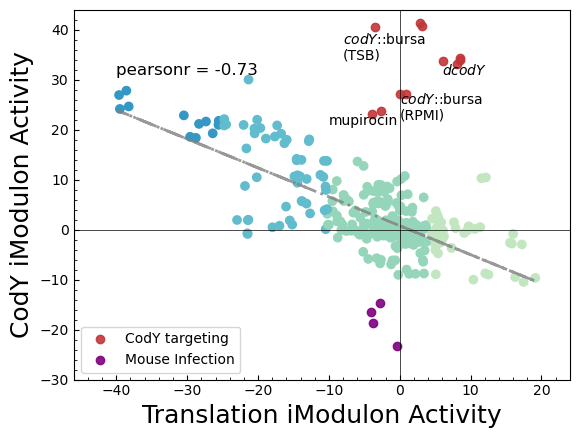

In [74]:
fig, ax = plt.subplots()

ax.scatter(usa_model.A.loc['Translation-1', reg_samples],
            usa_model.A.loc['CodY-1', reg_samples],
            c=usa_model.A.loc['Translation-1', reg_samples],
            cmap=ListedColormap(sns.color_palette('GnBu_r')[1:-1]))
# fit line
ax.plot(usa_model.A.loc['Translation-1'],
        slope * usa_model.A.loc['Translation-1'] + intercept,
        zorder=1, color='gray', linestyle='-.',
        lw=2, alpha=0.8)

# plot the CodY-KO
ax.scatter(usa_model.A.loc['Translation-1', cody_activation.index],
           usa_model.A.loc['CodY-1', cody_activation.index],
           color=(0.7561707035755478, 0.21038062283737025, 0.22352941176470587),
           alpha=0.9,
          label='CodY targeting')

# plot mouse infection
ax.scatter(usa_model.A.loc['Translation-1', mouse_infection],
           usa_model.A.loc['CodY-1', mouse_infection],
           color='purple',
           alpha=0.9,
           label='Mouse Infection')


ax.tick_params(which='both', axis='both', direction='in', bottom=True)
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(2))

ax.set_xlabel('Translation iModulon Activity', **label_font)
ax.set_ylabel('CodY iModulon Activity', **label_font)


ax.text(-40, 31, 'pearsonr = -0.73', **text_font)
ax.text(-8, 34, '$\it{codY}$::bursa\n(TSB)', **text_font_small)
ax.text(6, 31, '$d\it{codY}$', **text_font_small)
ax.text(0, 22, '$\it{codY}$::bursa\n(RPMI)', **text_font_small)
ax.text(-10, 21, 'mupirocin', **text_font_small)

ax.vlines(0, -34, 48, lw=0.5, color='black')
ax.hlines(0, -47, 26, lw=0.5, color='black')

ax.set_xlim(-46, 24)
ax.set_ylim(-30, 44)

plt.legend(loc=3, frameon=True)

# plt.savefig('PaperFigs/CodY_translation_corr.svg')

# Other Correlations

In [75]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear,
                           usa_model.A.loc['SigS'].values,
                          usa_model.A.loc['Translation-1'].values)
xd = np.linspace(usa_model.A.loc['SigS'].min(),
                usa_model.A.loc['Translation-1'].max())

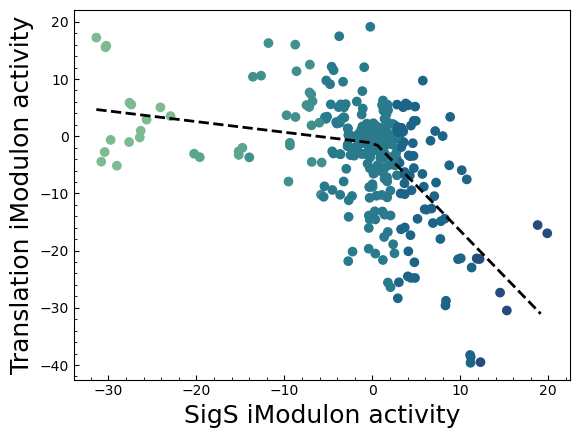

In [76]:
fig, ax = plt.subplots()
ax.scatter(usa_model.A.loc['SigS', reg_samples],
            usa_model.A.loc['Translation-1', reg_samples],
            c=usa_model.A.loc['SigS', reg_samples],
            cmap=ListedColormap(sns.color_palette('crest')))

ax.tick_params(which='both', axis='both', direction='in', bottom=True)
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(2))

ax.set_xlabel('SigS iModulon activity', fontdict=label_font)
ax.set_ylabel('Translation iModulon activity', fontdict=label_font)

ax.plot(xd, piecewise_linear(xd, *p), zorder=1, color='black', linestyle='--',
        lw=2)

Text(0, 0.5, 'CcpA iModulon activity')

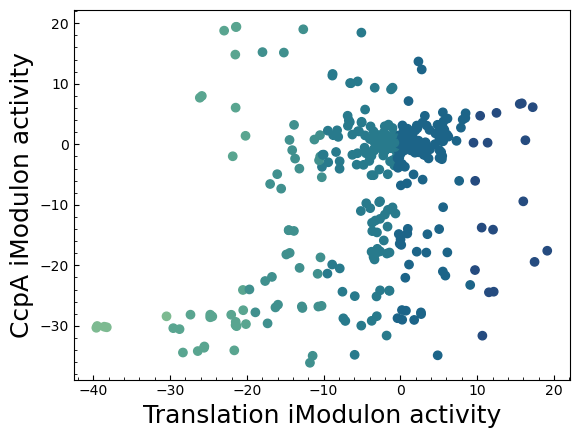

In [77]:
fig, ax = plt.subplots()
ax.scatter(usa_model.A.loc['Translation-1'],
            usa_model.A.loc['CcpA-1'],
            c=usa_model.A.loc['Translation-1'],
            cmap=ListedColormap(sns.color_palette('crest')))

ax.tick_params(which='both', axis='both', direction='in', bottom=True)
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(2))

ax.set_xlabel('Translation iModulon activity', fontdict=label_font)
ax.set_ylabel('CcpA iModulon activity', fontdict=label_font)

# plt.savefig('PaperFigs/Translation_CcpA_activity.svg')

# KO activities

Text(0, 0.5, 'ArlRS iModulon Activity')

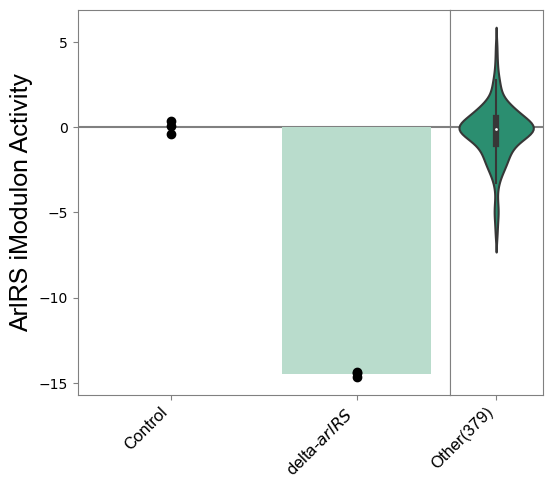

In [78]:
imod = 'ArlRS'

# should have the form {'project1': ['samp1', 'samp2'],
#                       'project2': ['samp1', 'samp2']}

samples = OrderedDict({'delta-arlRS': 
                       ['TSB;Control;stat;AH1263;WT',
                       'TSB;Mutant;stat;AH1263;Delta-arlRS']})

# double check to make sure labels match the samples
labels = ['delta-$\it{arlRS}$', 'Control']

err = 'Number of samples does not match the number of labels'
assert(len(list(itertools.chain(*samples.values()))) == len(labels)), err





cmap = plt.cm.get_cmap("Pastel2", 8)
colors = cmap(np.arange(cmap.N))

def get_mean(group):
    return [usa_model.A.loc[imod, grp.index].mean() for idx, grp in group.groupby('condition')]

# change [10,5] to change the size and shape of the plot
width_spaces = [len(samples[i]) for i in samples]
width_spaces.append(0.5)
fig, axes = plt.subplots(1, len(samples) + 1, figsize=[6,5], sharey=True,
                         gridspec_kw={'width_ratios': width_spaces})
plt.subplots_adjust(wspace=0, hspace=0)

used_index = []
for ax, prj, clr in zip(axes, samples, colors):
    cond = samples[prj]
    samps = usa_model.sample_table[(usa_model.sample_table.project == prj) &
                                 (usa_model.sample_table.condition.isin(cond))]
    used_index.extend(samps.index)
    bp = sns.barplot(x=np.arange(len(cond)), y=get_mean(samps), ax=ax, color=clr,
                    dodge=False)
    
    for xl, sgroup in zip(bp.get_xticks(), samps.groupby('condition')):
        sidx, sgrp = sgroup
        ax.scatter([xl] * len(sgrp), usa_model.A.loc[imod, sgrp.index], color='black',
                  zorder=10)
    new_width = 0.25 * len(cond)
    ax.hlines(0, 0 - new_width, len(cond), color='gray', zorder=-1)
    ax.set_xlim(0 - new_width, len(cond) - new_width)
    ax.set_xticklabels([labels.pop() for i in range(len(cond))],
                       rotation=45, ha='right', fontname='Arial', fontsize=12)

rest = usa_model.A.loc[imod, [i for i in usa_model.A if i not in used_index]]
sns.violinplot(x=[1] * len(rest), y=rest, ax=axes[-1], color='#1b9e77')

#clear ticks
for a in axes:
    a.tick_params(color='gray')
    for spine in a.spines.values():
        spine.set_edgecolor('gray')
for a in axes[1:]:
    a.tick_params(left=False)

axes[-1].set_ylabel('')
axes[-1].hlines(0, -2, 2, color='gray', zorder=-1)
axes[-1].set_xlim(-0.5, 0.5)
axes[-1].set_xticklabels([f'Other({len(rest)})'], rotation=45, ha='right',
                         fontname='Arial', fontsize=12)

axes[0].set_ylabel(f'{imod} iModulon Activity', fontname='Arial', fontsize=18)

# plt.savefig('PaperFigs/qcqa/ArlRS_imod_activity.svg')